# Overview

The purpose of this jupyter notebook is to outline a the problem, approach, and outcomes associated with the detection of "truthful" and "deceptive" hotel reviews that a typical hotel review aggregator (or some sort of similar service) would come across as important to business operations.

This notebook is structured in the following manner:
0. **Motivation**: The problem, and why it is important
1. **Setting up**: Tools, models, Data utilized
2. **Description**: A description of the data
3. **Data transformation**: Steps that facilitate the detection stage
4. **Classification**: The actual dete
5. **Optimization**: Improve the detection rate
6. **Future steps**: Steps to expand upon this work

## 1. Motivation

The problem of detecting truthful versus deceptive content is an important focus in many areas including spam detection, consumer-facing information about businesses, and even political information in democratic societies (fake news). 

The purpose of this project focuses on consumer-facing information. Given a data set of about 1600 hotel reviews, where 800 are truthful (pulled from sources such as Trip Advisor), and 800 are deceptive (Generated using Amazon's Mechanical Turk -- a market place for tasks requiring human intelligence), this notebook seeks to detect deceptive reviews by using latent semantic indexing and machine learning. 

## 2. Setting Up

In [100]:
# General Data Manipulation
import pandas
import numpy
import re

# Feature Engineering, Descriptives
from scipy.stats import ttest_ind
from nltk.corpus import stopwords
from collections import defaultdict

# NLP Modules
import gensim 
import spacy

# Supervised Learning Modules
from sklearn.lda import LDA 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Plotting
from matplotlib import pyplot
%matplotlib inline

# Read Data
data_in = pandas.read_csv('deceptive-opinion.csv')
stop = set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')

## 3. Description of Data

    A. Show the top 5 and bottom 5 records.
    B. Pivot table on categorical labels, and count.
    C. Barplot data
    D. Hypothesis testing

### A. Head / Tail of Data

In [101]:
data_in.head().append(data_in.tail())

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama..."


### B. Pivot Table by Categories

In [3]:
data_in.pivot_table(
    columns=['deceptive','polarity'],
    index = ['hotel'],
    aggfunc = len).fillna(0)

source                                 text           \
deceptive        deceptive          truthful          deceptive            
polarity          negative positive negative positive  negative positive   
hotel                                                                      
affinia                 20       20       20       20        20       20   
allegro                 20       20       20       20        20       20   
amalfi                  20       20       20       20        20       20   
ambassador              20       20       20       20        20       20   
conrad                  20       20       20       20        20       20   
fairmont                20       20       20       20        20       20   
hardrock                20       20       20       20        20       20   
hilton                  20       20       20       20        20       20   
homewood                20       20       20       20        20       20   
hyatt                   20       20       20       20        20       20   
intercontinental        20       20       20       20        20       20   
james                   20       20       20       20        20       20   
knickerbocker           20       20       20       20        20       20   
monaco                  20       20       20       20        20       20   
omni                    20       20       20       20        20       20   
palmer                  20       20       20       20        20       20   
sheraton                20       20       20       20        20       20   
sofitel                 20       20       20       20        20       20   
swissotel               20       20       20       20        20       20   
talbott                 20       20       20       20        20       20   

                                    
deceptive        truthful           
polarity         negative positive  
hotel                               
affinia                20       20  
allegro                20       20  
amalfi                 20       20  
ambassador             20       20  
conrad                 20       20  
fairmont               20       20  
hardrock               20       20  
hilton                 20       20  
homewood               20       20  
hyatt                  20       20  
intercontinental       20       20  
james                  20       20  
knickerbocker          20       20  
monaco                 20       20  
omni                   20       20  
palmer                 20       20  
sheraton               20       20  
sofitel                20       20  
swissotel              20       20  
talbott                20       20

### C. Barplot of Various Text Features

In [102]:
#Mean Length Funciton
def mean_len(group, mean = True):
    if mean == True:
        return numpy.mean(group.text.str.len())
    else:
        return group.text.str.len()

In [103]:
a = data_in.groupby(
    ['polarity']).apply(
    mean_len, mean = True)
b = data_in.groupby(
    ['deceptive','polarity']).apply(
    mean_len, mean = True)
c = data_in.groupby(
    ['hotel','polarity']).apply(
    mean_len, mean = True)

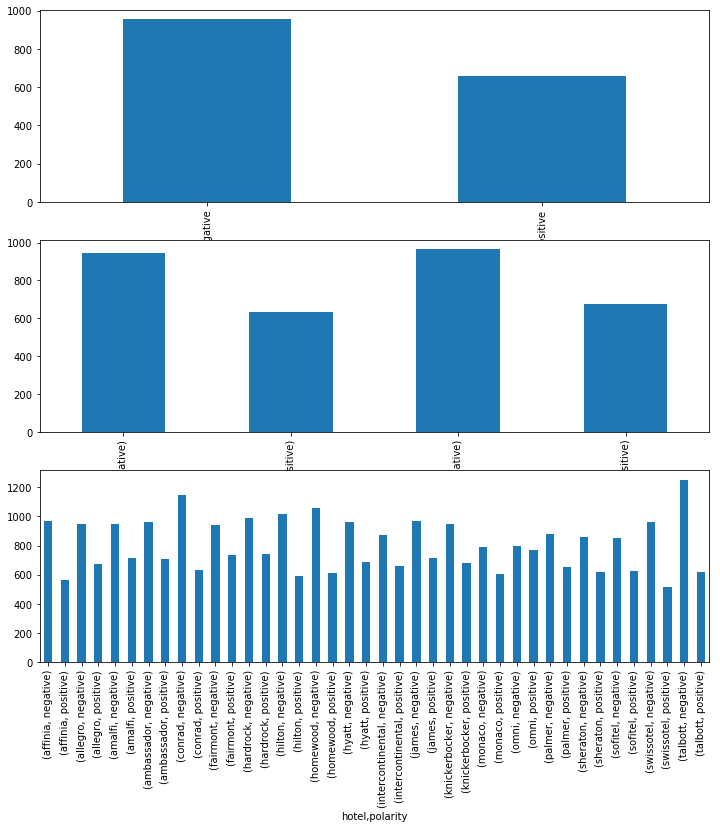

In [104]:
fig, ax =pyplot.subplots(3,1,figsize=(12,12))

a.plot('bar',ax = ax[0])

b.plot('bar',ax = ax[1])

c.plot('bar',ax = ax[2])

### A. Hypothesis Tests on Text Features

In [105]:
pandas.set_option('display.float_format', lambda x: '%.3f' % x)
test_a = ttest_ind(
    data_in[data_in.polarity == 'positive'].text.str.len(),
    data_in[data_in.polarity == 'negative'].text.str.len())

test_b = ttest_ind(
    data_in[data_in.source == 'TripAdvisor'].text.str.len(),
    data_in[data_in.source != 'TripAdvisor'].text.str.len())

test_c = ttest_ind(
    data_in[data_in.deceptive == 'deceptive'].text.str.len(),
    data_in[data_in.deceptive == 'truthful'].text.str.len())

test_a, test_b, test_c

(Ttest_indResult(statistic=-13.507204854821099, pvalue=1.8968798894685588e-39),
 Ttest_indResult(statistic=-6.4399626289335314, pvalue=1.5767614748756925e-10),
 Ttest_indResult(statistic=-1.2520931090803307, pvalue=0.21071916472895064))

# 4. Data Transformations

    A. Parse Data
    B. Create Features
    C. Topic Modeling
    D. Dummy variables
   

## A. Set up Instance and Parse Data

In [124]:
# Create Instance and Add Data to NLP object.
data_nlp = data_in.copy()
import en_core_web_md

nlp = en_core_web_md.load()


In [125]:
parsed = nlp.pipe(iter(data_nlp['text']), batch_size=1, n_threads=4)

# Create Features
tokens, lemma, parts, stopword = [], [], [], []

for parsed_doc in parsed:
    tokens.append([n.text for n in parsed_doc])
    lemma.append([n.lemma_ for n in parsed_doc])
    parts.append([n.pos_ for n in parsed_doc])
    stopword.append([n.is_stop for n in parsed_doc])

# Assign Parsed into Dataframe
data_nlp['tokens'] = tokens     
data_nlp['tokens_stopwords'] = data_nlp['tokens'].apply(lambda x: [item for item in x if item not in stop])
data_nlp['lemma'] = lemma
data_nlp['pos'] = parts
data_nlp['stopword'] = stopword

# Describe resulting frame
data_nlp.head(2).append(data_nlp.tail(2))

,deceptive,hotel,polarity,source,text,tokens,tokens_stopwords,lemma,pos,stopword
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,"[We, stayed, for, a, one, night, getaway, with...","[We, stayed, one, night, getaway, family, thur...","[-PRON-, stay, for, a, one, night, getaway, wi...","[PRON, VERB, ADP, DET, NUM, NOUN, NOUN, ADP, N...","[False, False, False, False, False, False, Fal..."
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,"[Triple, A, rate, with, upgrade, to, view, roo...","[Triple, A, rate, upgrade, view, room, less, $...","[triple, a, rate, with, upgrade, to, view, roo...","[ADJ, DET, NOUN, ADP, NOUN, PART, NOUN, NOUN, ...","[False, False, False, False, False, False, Fal..."
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i...","[The, Palmer, House, Hilton, ,, while, it, loo...","[The, Palmer, House, Hilton, ,, looks, good, p...","[the, palmer, house, hilton, ,, while, -PRON-,...","[DET, PROPN, PROPN, PROPN, PUNCT, ADP, PRON, V...","[False, False, False, False, False, False, Fal..."
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama...","[As, a, former, Chicagoan, ,, I, 'm, appalled,...","[As, former, Chicagoan, ,, I, 'm, appalled, Am...","[as, a, former, chicagoan, ,, -PRON-, be, appa...","[ADP, DET, ADJ, PROPN, PUNCT, PRON, VERB, VERB...","[False, False, False, False, False, False, Fal..."


## B. Create Features from Parsed Data

In [183]:
# Set up dataframe columns for new metrics
pron_ct = []
noun_ct = []
punct_ct = []
verb_ct = []
# tag parts of speech
for row in data_nlp.pos:
    pron_ct.append(sum([i == 'PRON'  for i in row]))
    noun_ct.append(sum([i == 'NOUN'  for i in row]))
    punct_ct.append(sum([i == 'PUNCT'  for i in row]))
    verb_ct.append(sum([i == 'VERB'  for i in row]))

## Create Number of stopword
stop_row = []
for row in data_nlp.stopword:
    stop_row.append(sum(row))
    
# Create POS Counts
data_nlp['pron_ct'] = pron_ct
data_nlp['noun_ct'] = noun_ct
data_nlp['punct_ct'] = punct_ct
data_nlp['verb_ct'] = verb_ct
data_nlp['stoprow'] = stop_row
# Describe Data
data_nlp.head(2).append(data_nlp.tail(2))

,deceptive,hotel,polarity,source,text,tokens,tokens_stopwords,lemma,pos,stopword,pron_ct,noun_ct,punct_ct,verb_ct,stoprow
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,"[We, stayed, for, a, one, night, getaway, with...","[We, stayed, one, night, getaway, family, thur...","[-PRON-, stay, for, a, one, night, getaway, wi...","[PRON, VERB, ADP, DET, NUM, NOUN, NOUN, ADP, N...","[False, False, False, False, False, False, Fal...",5,30,12,14,0
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,"[Triple, A, rate, with, upgrade, to, view, roo...","[Triple, A, rate, upgrade, view, room, less, $...","[triple, a, rate, with, upgrade, to, view, roo...","[ADJ, DET, NOUN, ADP, NOUN, PART, NOUN, NOUN, ...","[False, False, False, False, False, False, Fal...",0,14,9,4,0
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i...","[The, Palmer, House, Hilton, ,, while, it, loo...","[The, Palmer, House, Hilton, ,, looks, good, p...","[the, palmer, house, hilton, ,, while, -PRON-,...","[DET, PROPN, PROPN, PROPN, PUNCT, ADP, PRON, V...","[False, False, False, False, False, False, Fal...",10,17,13,20,0
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama...","[As, a, former, Chicagoan, ,, I, 'm, appalled,...","[As, former, Chicagoan, ,, I, 'm, appalled, Am...","[as, a, former, chicagoan, ,, -PRON-, be, appa...","[ADP, DET, ADJ, PROPN, PUNCT, PRON, VERB, VERB...","[False, False, False, False, False, False, Fal...",25,40,29,61,0


## C. Topic Modeling

In [127]:
# helper function

def build_model(train_data, topic_n):
    frequency = defaultdict(int)
    for text in train_data:
        for token in text:
            frequency[token] += 1
    # get freq > 1
    word_freq_1plus = [[x for x in words if frequency[x] > 1] for words in train_data]
    # Create dictionary
    dictionary = gensim.corpora.Dictionary(word_freq_1plus)
    # Create Corpus
    corpus = [dictionary.doc2bow(text) for text in train_data]
    # corpus to tfidf
    tfidf = gensim.models.TfidfModel(corpus) 
    corp_tf = tfidf[corpus] 
    # Unsupervised Component. Reduce space into 300 topics. 
    topic_n = topic_n
    lsi = gensim.models.LsiModel(corp_tf, id2word=dictionary, num_topics = topic_n)
    corp_topics = lsi[corp_tf] 
    return corp_topics, dictionary, tfidf, lsi  

train_data = data_nlp.tokens_stopwords
topic_n = 300

built = build_model(
    train_data = train_data,
    topic_n = 300)

## D. Add dummy variables

In [129]:
data_nlp_decomposed = pandas.DataFrame([dict(row) for row in built[0]])
topic_only = data_nlp_decomposed

In [ ]:
data_nlp_decomposed = pandas.concat(
    [data_nlp_decomposed,
     data_nlp[['pron_ct', 'noun_ct', 'punct_ct', 'verb_ct','stopword']],
     pandas.get_dummies(data_nlp[['hotel','polarity']])],
    axis = 1)

In [133]:
data_nlp_decomposed.head(3).append(data_nlp_decomposed.tail(3))

,0,1,2,3,4,5,6,7,8,9,...,hotel_knickerbocker,hotel_monaco,hotel_omni,hotel_palmer,hotel_sheraton,hotel_sofitel,hotel_swissotel,hotel_talbott,polarity_negative,polarity_positive
0,0.142,0.025,-0.095,0.058,0.054,0.073,-0.040,-0.008,0.031,0.048,...,0,0,0,0,0,0,0,0,0,1
1,0.091,0.079,-0.116,0.052,0.028,-0.085,0.055,0.037,-0.050,-0.032,...,0,0,0,0,0,0,0,0,0,1
2,0.229,0.021,-0.063,0.034,-0.022,-0.031,0.036,0.021,-0.023,0.047,...,0,0,0,0,0,0,0,0,0,1
1597,0.135,-0.025,0.009,-0.007,-0.041,-0.026,0.029,0.021,-0.038,0.017,...,0,0,0,0,0,0,0,0,1,0
1598,0.165,-0.106,0.029,0.068,-0.054,-0.015,0.072,-0.032,-0.057,-0.105,...,0,0,0,1,0,0,0,0,1,0
1599,0.246,-0.106,0.060,-0.083,-0.083,0.004,0.022,-0.003,0.034,0.000,...,0,0,0,0,0,0,0,0,1,0


# 5. Classification and Tuning

Below, three sets of 6 models are run with 10 folds cross validation. Each set successively adds more data:

- X1: 300 Topics Only from Latent Semantic Indexing
- X2: X1 + Parts of Speech Metrics
- X3: X2 + Dummy variables from dataset


## A.  Setting up data + Models

In [166]:
# Setting Up Three Datasets
X1 = topic_only
X2 = pandas.concat(
    [topic_only,
     data_nlp[['pron_ct', 'noun_ct', 'punct_ct', 'verb_ct']]],
    axis = 1)
X3 = pandas.concat(
    [X3,
     pandas.get_dummies(data_nlp[['hotel','polarity']])],
    axis = 1)
Y = data_nlp.deceptive == 'deceptive'

In [145]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [179]:
# evaluate each model in turn

def run_models(train_data):
    results = []
    names = []

    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, train_data, Y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    # boxplot algorithm comparison
    fig = pyplot.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    pyplot.boxplot(results)
    ax.set_xticklabels(names)
    pyplot.show()

### Model Comparison 1:
Compare 6 Models with variables:
- 300 Topics

In [177]:
X1.shape

(1600, 300)

In [178]:
X1.columns.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

LR: 0.754375 (0.071209)
LDA: 0.832500 (0.035990)
KNN: 0.558750 (0.083769)
CART: 0.708750 (0.049624)
NB: 0.664375 (0.144726)
SVM: 0.174375 (0.348775)


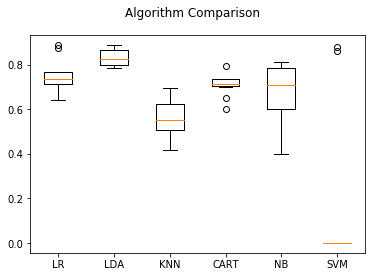

In [180]:
run_models(X1)

### Model Comparison 2:
Compare 6 Models with variables:
- 300 Topics
- Parts of Speech Metrics

In [171]:
X2.shape

(1600, 304)

In [172]:
X2.columns.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 20

LR: 0.722500 (0.068988)
LDA: 0.833125 (0.038431)
KNN: 0.497500 (0.087509)
CART: 0.710000 (0.048348)
NB: 0.658125 (0.134195)
SVM: 0.468125 (0.107654)


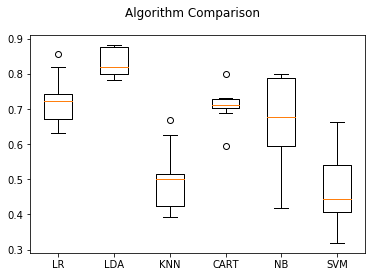

In [181]:
run_models(X2)

### Model Comparison 3:
Compare 6 Models with variables:
- 300 Topics
- Parts of Speech Metrics
- Dummy Variables

In [174]:
X3.shape

(1600, 344)

In [175]:
X3.columns.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 20

LR: 0.376875 (0.160810)
LDA: 0.781875 (0.049089)
KNN: 0.000000 (0.000000)
CART: 0.720625 (0.051543)
NB: 0.004375 (0.006281)
SVM: 0.000000 (0.000000)


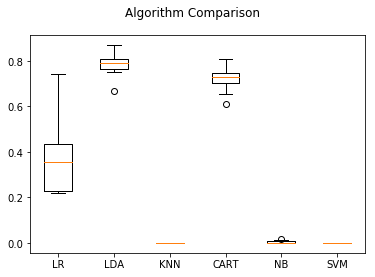

In [182]:
run_models(X3)